# Exploratory Data Analysis

dependencies

In [22]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import geometry_mask
from matplotlib.colors import ListedColormap, BoundaryNorm

## Image

single image

In [24]:
sentinel_2 = rio.open('data/dataset/raw/train/images/2016_Q1.tif')

### Image Attributes

Band Count

In [25]:
sentinel_2.count

4

Dimensions

In [26]:
print('Height:', sentinel_2.height)
print('Width:', sentinel_2.width)

Height: 823
Width: 1008


### Dataset Georeferencing

Bounding Box

In [27]:
sentinel_2.bounds

BoundingBox(left=120.54510763905542, bottom=16.360567112026786, right=120.63565781969466, top=16.434498459909822)

In [28]:
sentinel_2.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [29]:
sentinel_2.indexes

(1, 2, 3, 4)

### Visualization

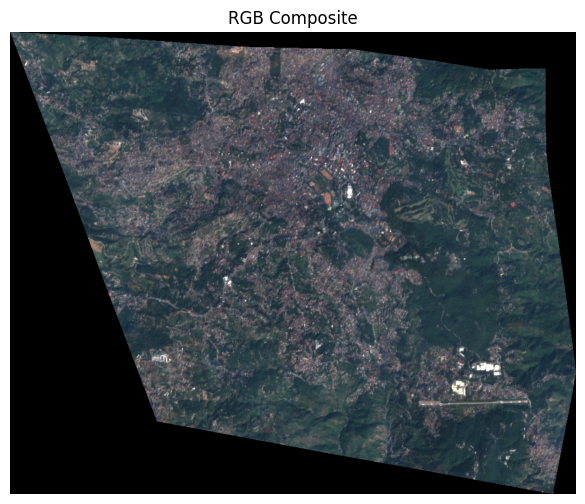

In [30]:
image = np.transpose(sentinel_2.read(), (1, 2, 0))

rgb = image[:, :, :3]

rgb = np.nan_to_num(rgb, nan=0.0)

rgb = np.clip(rgb, 0, 0.3)
rgb = rgb / 0.3

plt.figure(figsize=(8, 6))
plt.imshow(rgb)
plt.title("RGB Composite")
plt.axis('off')
plt.show()

## MASK

In [124]:
dynamic_world_v1 = rio.open('data/dataset/raw/train/masks/2017_Q1_mask.tif')

### MASK ATTRIBUTES

Band Count

In [125]:
dynamic_world_v1.count

1

Dimensions

In [126]:
print('Height:', dynamic_world_v1.height)
print('Width:', dynamic_world_v1.width)

Height: 823
Width: 1008


In [127]:
mask = dynamic_world_v1.read(1)

mask


array([[6, 6, 6, ..., 0, 0, 0],
       [0, 6, 6, ..., 0, 0, 0],
       [0, 6, 6, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(823, 1008), dtype=uint8)

In [128]:
counts = np.bincount(mask.flatten(), minlength=12)

special_counts = {value: count for value, count in enumerate(counts) if count > 0}

print(special_counts)

{0: np.int64(225629), 1: np.int64(245731), 2: np.int64(9149), 4: np.int64(978), 5: np.int64(4031), 6: np.int64(343606), 7: np.int64(191), 8: np.int64(269)}


### Visualization

In [129]:
boundary = gpd.read_file('data/bc_boundary/bc_boundary.shp')
boundary = boundary.to_crs(dynamic_world_v1.crs)

transform = sentinel_2.transform

In [130]:
h, w = sentinel_2.shape

city_mask = geometry_mask(
    [feature['geometry'] for feature in boundary.to_dict('records')],
    transform=transform,
    invert=True,
    out_shape=(h, w),
)

mask[~city_mask] = 255

In [131]:
dw_colors = [
    "#419bdf",  # 0 water
    "#397d49",  # 1 trees
    "#88b053",  # 2 grass
    "#7a87c6",  # 3 flooded_vegetation
    "#e49635",  # 4 crops
    "#dfc35a",  # 5 shrub_and_scrub
    "#c4281b",  # 6 built
    "#a59b8f",  # 7 bare
    "#b39fe1",  # 8 snow_and_ice
]

cmap = ListedColormap(dw_colors)

cmap.set_bad(color="black")

masked = np.ma.masked_where(mask == 255, mask)

bounds = np.arange(10) - 0.5
norm = BoundaryNorm(bounds, cmap.N)

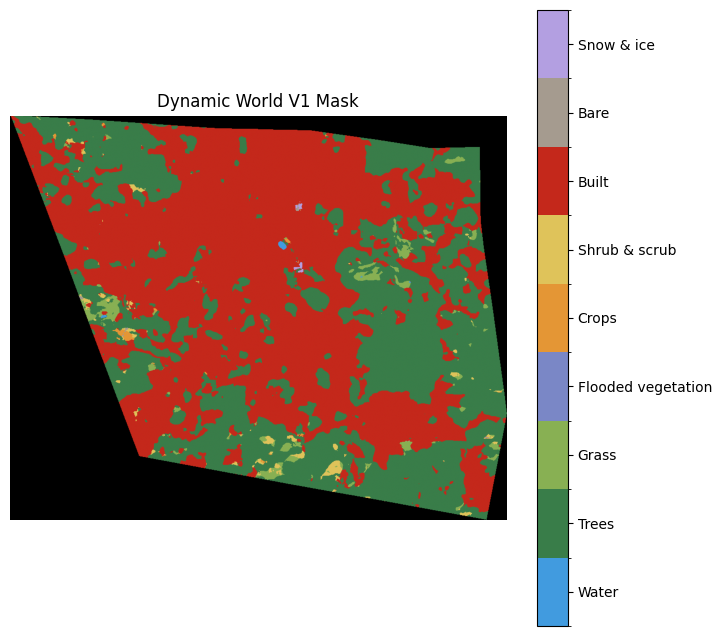

In [132]:
plt.figure(figsize=(8, 8))
img = plt.imshow(masked, cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ticks=np.arange(9))

cbar.ax.set_yticklabels([
    "Water",
    "Trees",
    "Grass",
    "Flooded vegetation",
    "Crops",
    "Shrub & scrub",
    "Built",
    "Bare",
    "Snow & ice"
])

plt.title("Dynamic World V1 Mask")
plt.axis("off")
plt.show()